# Estimating Extreme Risks and Dependence of Stock Indices
#### Research Project for the Course Quantitative Risk Management
Authors: **Nicolo Giacopelli & Oskar Girardin**

## I – Empirical/descriptive analysis

In [13]:
# Import libraries
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import yahooquery as yq
from scipy.stats import norm, kurtosis, skew
from itertools import combinations
from collections import defaultdict
import matplotlib.ticker as mtick
from statsmodels.distributions.copula.api import StudentTCopula
import pycopula

# Define colors of graphs
DARK_COL = "#138086"
LIGHT_COL = "#f0b64d"
sns.set_style("whitegrid")

# Function to get tickers of S&P 500
tickers_indeces = ["^GSPC", "^GDAXI", "^FTSE"]

In [14]:
# Download data from 1987 to end of 2022
start = datetime.datetime(1987, 1, 1)
end = datetime.datetime(2022, 12, 31)
data = yf.download(tickers_indeces, start = start, end = end)
prices = data["Adj Close"]


# Rename columns
prices = prices.rename({"^GSPC": "SP500", "^GDAXI": "DAX", "^FTSE": "FTSE"}, axis = 1)

prices


[*********************100%***********************]  3 of 3 completed


,FTSE,DAX,SP500
Date,,,
1987-01-02,1681.099976,NaN,246.449997
1987-01-05,1680.000000,NaN,252.190002
1987-01-06,1690.699951,NaN,252.779999
1987-01-07,1722.199951,NaN,255.330002
1987-01-08,1733.099976,NaN,257.279999
...,...,...,...
2022-12-23,7473.000000,13940.929688,3844.820068
2022-12-27,NaN,13995.099609,3829.250000
2022-12-28,7497.200195,13925.599609,3783.219971


### 1. Show the plot of the daily prices, $p_i$ of the S&P 500, then describe what you see

In [186]:

def plot_time_series(df, col_name, ylab = 'Price (in US $)', title = None, xlab = "Date", perc=False, save = False, end_markers = False):
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.plot(df.index, df[col_name], color = DARK_COL)

    # Set the axis labels and title
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)
    ax.set_title(title, fontsize=20, y=1.02)
    ax.grid(False)
    if perc:
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    
    # End markers
    if end_markers:
        ax.scatter(df.index[0], df[col_name][0], color = DARK_COL)
        ax.scatter(df.index[-1], df[col_name][-1], color = DARK_COL)

        ax.text(df.index[0], df[col_name][0]+200, s=f"{df[col_name][0]: .0f}",
                fontsize = 12, 
                horizontalalignment = "center",
                verticalalignment = "center"
                )
        ax.text(df.index[-1], df[col_name][-1]-200, s=f"{df[col_name][-1]: .0f}", fontsize = 12)

    # Tick size
    plt.yticks(fontsize=13)
    plt.xticks(fontsize=13)
    
    # Save plot
    if save:
        plt.savefig(f"./imgs/{title}")
    
    # Show the plot
    plt.show()




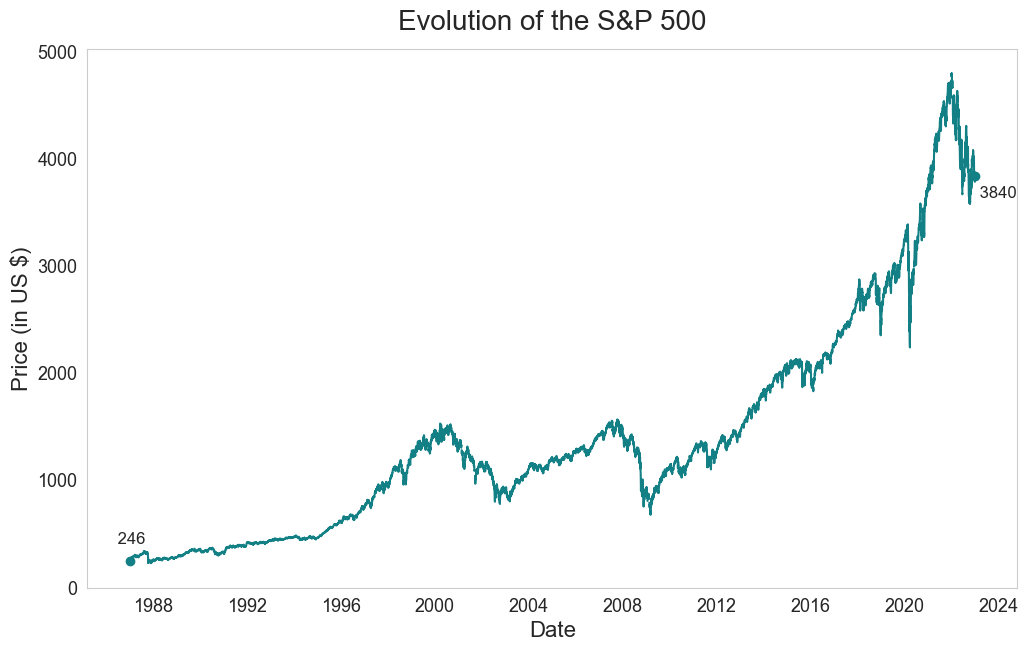

In [187]:
plot_time_series(prices, "SP500", title="Evolution of the S&P 500", save=True, end_markers=True)

### 2. Transform your three data sets to consider now the daily log return: $$x_i = \log p_i - \log p_{i-1}$$ and give a plot of this new data set (x_i, i = 1,...,n) for the S&P 500. What do you notice? Why did we perform this transformation? We consider the obtained returns as realization of three random variables (rv)’s: $U$ the rv for the S&P 500 returns, $V$ the rv for the FTSE returns, and $W$ the rv for the DAX.

In [17]:
def to_log_returns(prices: pd.DataFrame):
    log_prices = np.log(prices)
    prices_diff = log_prices.diff(periods = 1, axis = 0) * 100
    # Dropping first (lost) observation
    prices_diff = prices_diff.iloc[1:, :]
    return prices_diff

returns = to_log_returns(prices)
returns



,FTSE,DAX,SP500
Date,,,
1987-01-05,-0.065453,NaN,2.302366
1987-01-06,0.634882,NaN,0.233676
1987-01-07,1.845990,NaN,1.003729
1987-01-08,0.630918,NaN,0.760815
1987-01-09,1.101754,NaN,0.562011
...,...,...,...
2022-12-23,0.049526,0.192851,0.585095
2022-12-27,NaN,0.387815,-0.405784
2022-12-28,NaN,-0.497840,-1.209347


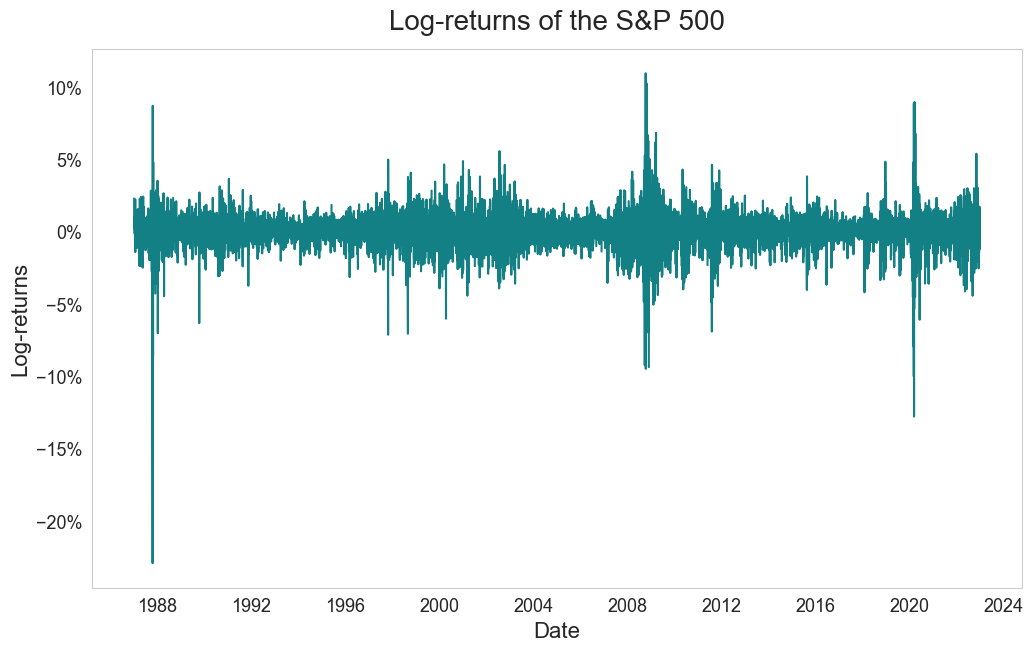

In [135]:

plot_time_series(returns, "SP500", ylab="Log-returns", title= "Log-returns of the S&P 500", perc=True, save=True)


### 3. Present your empirical analysis done on these later data sets in two tables, one for the basic statistics containing: 
1. Descriptive statistics (number of observations, $\mu$, $\sigma$, skewness, kurtosis) 
2. Rank statistics (Maximum, Median, Minimum)

In [19]:
def compute_stats(df):
    moment_functions = ["count", "mean", "std", "skew", "kurt", "min", "median", "max"]
    return df.agg(moment_functions, axis=0)

In [188]:
basic_stats = compute_stats(returns)
basic_stats.transpose()

,count,mean,std,skew,kurt,min,median,max
FTSE,8899.0,0.013478,1.114502,-0.570827,10.467729,-13.028599,0.050032,9.384244
DAX,8668.0,0.023807,1.395603,-0.295273,6.780182,-14.091166,0.073606,10.797468
SP500,8855.0,0.031087,1.179902,-1.208194,25.841746,-22.899729,0.060670,10.957197


In [201]:
" & ".join([str(round(x,3)) for x in list(basic_stats.transpose().loc["SP500"])])

'8855.0 & 0.031 & 1.18 & -1.208 & 25.842 & -22.9 & 0.061 & 10.957'

In [21]:
def _get_risk_measure_df(df, method, alpha):
    if method == "VaR":
        return pd.Series(np.nanquantile(df, q = alpha, axis = 0), index = df.columns)
    elif method == "tVaR":
        return df[df > np.nanquantile(df, q = alpha, axis = 0)].mean(axis=0)
    else:
        return -1
    
def _get_risk_measure_series(series, method, alpha):
    if method == "VaR":
        return np.nanquantile(series, q = alpha)
    elif method == "tVaR":
        return series[series > np.nanquantile(series, q = alpha, axis = 0)].mean(axis=0)
    else:
        return -1

def get_risk_measure(x, method, alpha):
    return _get_risk_measure_df(x, method, alpha) if isinstance(x, pd.DataFrame) else _get_risk_measure_series(x, method, alpha)


In [22]:

alpha_var = 0.995
alpha_tvar = 0.99

# Define losses as negative returns
losses = -returns

# Get VAR at 99.5%
VAR = get_risk_measure(losses, "VaR", alpha_var)
# Get tVAR at 99%
tVAR = get_risk_measure(losses, "tVaR", alpha_tvar)


# Get VAR and tVAR using gaussian model
gauss = norm(loc=0, scale=1)
# Mean and Std of Losses (!!!! we cannot use the same mean as before since now we are using the LOSSES !!!!)
moments = ["mean", "std"]
losses_stats = losses.agg(moments, axis=0)

means = losses_stats.loc["mean", :]
stds = losses_stats.loc["std", :]

VAR_gaussian = means + stds*gauss.ppf(alpha_var)  # inverse of cdf
tVAR_gaussian = means + stds*(gauss.pdf(gauss.ppf(alpha_tvar)))/(1-alpha_tvar) 


# Combine into one dataframe
risk_measures = pd.DataFrame([VAR, VAR_gaussian, tVAR, tVAR_gaussian], index = ["VAR_empirical", "VAR_gaussian", 
                                                                                "tVAR_empirical", "tVAR_gaussian"])
risk_measures


,FTSE,DAX,SP500
VAR_empirical,3.921858,5.075333,4.120442
VAR_gaussian,2.857289,3.571027,3.008139
tVAR_empirical,4.551729,5.437801,5.007729
tVAR_gaussian,2.956908,3.695773,3.113605


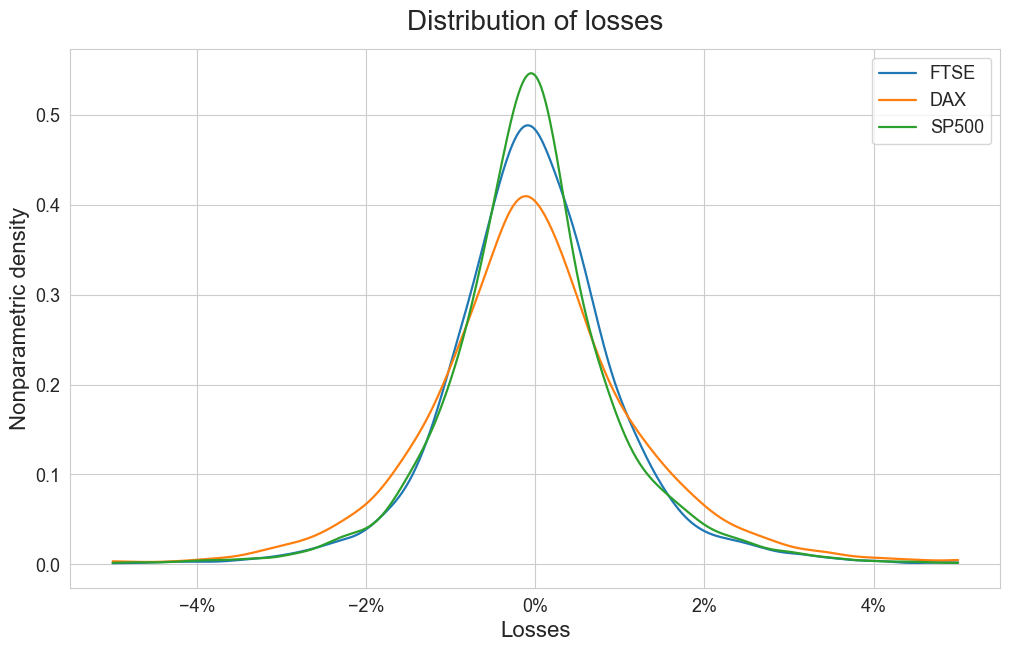

In [23]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 7))

for i in range(3):
    values = losses.iloc[:,i].dropna().copy()
    d = stats.gaussian_kde(values)
    ind = np.linspace(-5, 5, 500)
    kdepdf = d.evaluate(ind)
    plt.plot(ind, kdepdf, label=losses.columns[i], linewidth=1.6)

# Set the axis labels and title
plt.xlabel("Losses", fontsize=16)
plt.ylabel("Nonparametric density", fontsize=16, x=-0.8)
plt.title("Distribution of losses", fontsize=20, y=1.02)
plt.legend(fontsize=13)

# Ticks
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
    
    
# Show the plot
plt.show()


In [ ]:
first_day_dax = prices["DAX"][prices["DAX"].notna()].index[0]
prices_sync = prices[prices.index >= first_day_dax]
prices_sync = prices.interpolate(method="linear", axis = 0)
returns_sync = to_log_returns(prices_sync)
losses_sync = -returns_sync

In [87]:
# First we linearly interpolate missing values (suggested in class)
# this is done not to lose too many observations, as we would pass from 9293 observations to 8074 (-13%) if doing returns.dropna()

#returns.interpolate(method="linear", axis=0, inplace=True)

# Importantly, first available observation for DAX is 5th January 1988 (entire 1987 is missing)
# interpolation clearly cannot be done in this interval, which will still be Missing
# all Rank statistics are not affected, as it is done with a linear combination (while Mean might slightly change for instance)

first_day_dax = returns["DAX"][returns["DAX"].notna()].index[0]
returns_sync = returns[returns.index >= first_day_dax]

# Fill with mean
returns_mean = returns.agg("mean", axis = 0)
returns_sync = returns_sync.fillna(returns_mean)

losses_sync = -returns_sync

### e. Build a portfolio, $Z = U + V + W$, with the three indices and compute the empirical VaR of the losses at 99.5% and the TVaR at 99%. Allocate the capital according to: $C(L|P) = \mathbb{E}[L] - \mathbb{E}[L|Z \leq F_Z^{-1}(\alpha)]$, to the three indices in the portfolio.

In [98]:
# We take the mean of the losses so that we will be able to compare individual risk measures with those of the portfolio
Z = losses_sync.sum(axis = 1)

In [99]:
# Compute risk measures for Z
VaR_Z = get_risk_measure(Z, "VaR", alpha_var)
tVaR_Z = get_risk_measure(Z, "tVaR", alpha_tvar)
print(f"Risk measures of portfolio:\nVaR: {VaR_Z: .4f}\ntVaR: {tVaR_Z: .4f}")

Risk measures of portfolio:
VaR:  11.3081
tVaR:  12.4913


In [100]:
# Compute capital allocated without risky part
mean_losses = losses_sync.mean(axis = 0)
capital_alloc = np.mean(losses_sync, axis = 0) - np.mean(losses_sync[Z <= VaR_Z], axis = 0)

In [101]:
# Compute capital allocated with risky part (kind of ES of portfolio)
capital_alloc2 = np.mean(losses_sync[Z >= VaR_Z], axis = 0) - np.mean(losses_sync, axis = 0)

In [102]:
capital_alloc

FTSE     0.024101
DAX      0.029438
SP500    0.023875
dtype: float64

In [103]:
capital_alloc2

FTSE     4.710189
DAX      5.753199
SP500    4.665941
dtype: float64

### f. Diversification benefits

In [104]:
def get_div_benefits(C_X_P, C_X):
    return 1 - C_X_P/C_X

def get_C_X(losses):
    return get_risk_measure(losses, "VaR", alpha_var) - losses.mean(axis = 0)

def get_C_X2(losses):
    return losses.mean(axis = 0) - np.mean(losses_sync[losses_sync <= VAR], axis = 0)

In [105]:
VAR

FTSE     3.921858
DAX      5.075333
SP500    4.120442
dtype: float64

In [106]:
C_X = get_C_X2(losses)
C_X

FTSE     0.022918
DAX      0.031335
SP500    0.027878
dtype: float64

In [107]:
get_div_benefits(capital_alloc, C_X)

FTSE    -0.051620
DAX      0.060547
SP500    0.143599
dtype: float64

### e. RoRAC

In [83]:
mean_returns = returns_sync.mean()
mean_returns

FTSE     0.016023
DAX      0.029082
SP500    0.029548
dtype: float64

In [84]:
yearly_returns = mean_returns * 252
yearly_VaR = VAR * np.sqrt(252)
yearly_tVaR = tVAR * np.sqrt(252)

In [85]:
yearly_returns

FTSE     4.037732
DAX      7.328599
SP500    7.446212
dtype: float64

In [47]:
rorac_standalone_VaR = yearly_returns/yearly_VaR
rorac_standalone_tVaR = yearly_returns/yearly_tVaR
print(f"VaR\n{rorac_standalone_VaR}\n------------------\ntVaR\n{rorac_standalone_tVaR}")

VaR
FTSE     0.053812
DAX      0.074464
SP500    0.121145
dtype: float64
------------------
tVaR
FTSE     0.046366
DAX      0.069500
SP500    0.099680
dtype: float64


In [48]:
# RoRAC portfolio
yearly_return_Z = (-Z).mean() * 252
yearly_VaR_Z = VaR_Z * np.sqrt(252)
yearly_tVaR_Z = tVaR_Z * np.sqrt(252)
rorac_Z = yearly_return_Z/pd.Series([yearly_VaR_Z, yearly_tVaR_Z], index = ["VaR", "tVaR"])
rorac_Z

VaR     0.096227
tVaR    0.087112
dtype: float64

In [49]:
# RoRAC indeces in portfolio based on capital allocated looking at ES of portfolio (unsure)
yearly_returns / yearly_VaR_Z

FTSE     0.055989
DAX      0.100263
SP500    0.132428
dtype: float64

## III. Bivariate analyis

### Draw the ranked scatter plot for the three pairs, do you see a difference?

In [117]:
first_day_dax = prices["DAX"][prices["DAX"].notna()].index[0]
prices_sync = prices[prices.index >= first_day_dax]
prices_sync = prices_sync.interpolate(method="linear", axis = 0)

returns_bivariate = to_log_returns(prices_sync)

losses_bivariate = -returns_bivariate

In [57]:
losses_bivariate = losses.dropna()

In [136]:
ftse = losses_bivariate["FTSE"]
dax = losses_bivariate["DAX"]
sp500 = losses_bivariate["SP500"]


def plot_rankscatter(series1, series2, ax, title = None):
    ranks1 = stats.rankdata(series1)
    ranks2 = stats.rankdata(series2)

    ax.scatter(ranks1, ranks2, s = 2, color = DARK_COL)
    ax.grid(False)
    ax.set_xlabel(series1.name)
    ax.set_ylabel(series2.name)
    ax.set_title(title)

def plot_rankscatters(save = False):
    fig, axs = plt.subplots(ncols=3, figsize = (20, 6))
    for i, (x, y) in enumerate(combinations([ftse, dax, sp500], r = 2)):
        ranks_x = stats.rankdata(x)
        ranks_y = stats.rankdata(y)
        cor_spearman = stats.spearmanr(x, y)
        axs[i].scatter(ranks_x, ranks_y, s = 2, color = DARK_COL)
        axs[i].grid(False)
        axs[i].set_xlabel(x.name)
        axs[i].set_ylabel(y.name)
        axs[i].set_title(f"{x.name} & {y.name} (Spearman: {cor_spearman.statistic: .2f})")

    if save:
        plt.savefig("./imgs/Rankscatters")
        
    plt.show()

In [120]:
#plot_rankscatter(ftse, dax)

In [121]:
#plot_rankscatter(ftse, sp500)

In [122]:
#plot_rankscatter(sp500, dax)

### Compute the Spearman and the Pearson correlation, what do you obtain?

In [123]:
# Spearman and Pearson coefficients
def get_correlations(*series_list):
    # Get all combinations of 2 elements in series_list
    combs = combinations(list(series_list), r = 2)
    res = pd.DataFrame(np.zeros((len(list(series_list)), 2)), columns=["Spearman", "Pearson"])
    # Get the names of the elements for indexing the final dataframe
    combs_names = combinations(list(series_list), r = 2)
    combs_names = [(x.name, y.name) for x, y in list(combs_names)]
    res = res.reindex(combs_names)
    # Compute correlations for every combination
    for i, (x, y) in enumerate(combs):
        cor_spearman = stats.spearmanr(x, y)
        cor_pearson = stats.pearsonr(x, y)
        res.iloc[i] = [cor_spearman.statistic, cor_pearson.statistic]
    return res

In [124]:
np.corrcoef(np.array([sp500, dax, ftse]))

array([[1.        , 0.52556694, 0.50565194],
       [0.52556694, 1.        , 0.75811092],
       [0.50565194, 0.75811092, 1.        ]])

In [125]:
def get_correlations(*series_list):
    names = [x.name for x in list(series_list)]
    print("Spearman correlation")
    corrs_spearman = stats.spearmanr(np.array([sp500, dax, ftse]).transpose()).statistic
    df_corrs_spearman = pd.DataFrame(corrs_spearman, columns = names, index = names)
    print(df_corrs_spearman)
    
    print("-----------------------------------")
    print("Pearson correlation")
    corrs_pearson = np.corrcoef(np.array([sp500, dax, ftse]))
    df_corrs_pearson = pd.DataFrame(corrs_pearson, columns = names, index = names)
    print(df_corrs_pearson)
    return df_corrs_spearman, df_corrs_pearson

In [126]:
df_corrs_spearman, df_corrs_pearson = get_correlations(sp500, dax, ftse)

Spearman correlation
          SP500       DAX      FTSE
SP500  1.000000  0.448836  0.433973
DAX    0.448836  1.000000  0.701475
FTSE   0.433973  0.701475  1.000000
-----------------------------------
Pearson correlation
          SP500       DAX      FTSE
SP500  1.000000  0.525567  0.505652
DAX    0.525567  1.000000  0.758111
FTSE   0.505652  0.758111  1.000000


### Suggest copulas to model dependence and fit them to your data

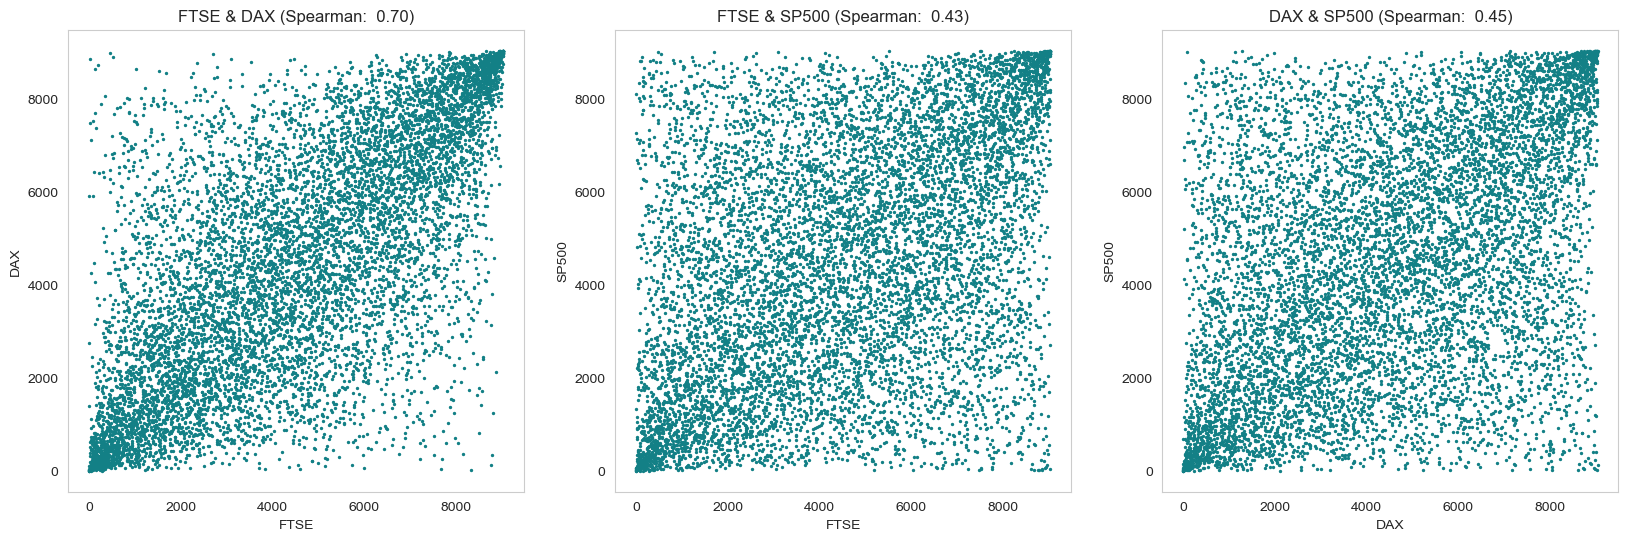

In [137]:
plot_rankscatters(save=True)

Available choices: *Clayton, survival Clayton, Gumbel, Student, Gaussian*\
\
Clayton, survival clayton always can be ruled out (dependence on both sides).
1. FTSE & DAX: **Student-t** (off-diagonal elements in matrix around 0.8, deg. of freedoms of around 7-9)\
Symmetric (no Gumbel), some outliers in top-left and bottom-right corners (no Gauss)
2. FTSE & S&P 500: **Student-t** (off-diagonal elements in matrix around 0.5-0.6, deg. of freedoms of around 7-9)\
Symmetric (no Gumbel), a lot of outliers in top-left and bottom-right corners (no Gauss)
3. DAX & S&P 500: **Student-t** (off-diagonal elements in matrix around 0.5-0.6, deg. of freedoms of around 7-9)\
Symmetric (no Gumbel), a lot of outliers in top-left and bottom-right corners (no Gauss)


In [67]:
def plot_copula(ax_plot, ax_none, rho = 0.8, deg_freedom = 4):
    R1 = np.full((2,2), rho)
    np.fill_diagonal(R1, 1)
    student_copula = StudentTCopula(R1, deg_freedom)
    sample = student_copula.plot_scatter(nobs = len(dax), ax = ax_none)
    fig.delaxes(ax_none)
    x, y = sample[1].transpose()
    ax_plot.scatter(x, y, s = 2, color = DARK_COL)
    ax_plot.grid(False)
    ax_plot.set_title(f"Copula (corr: {student_copula.corr[1][0]: .4f}), deg. of freedom: {student_copula.df}")

#### FTSE & DAX: Student copula
- rho: 0.7461536 
- df: 4.0000000 

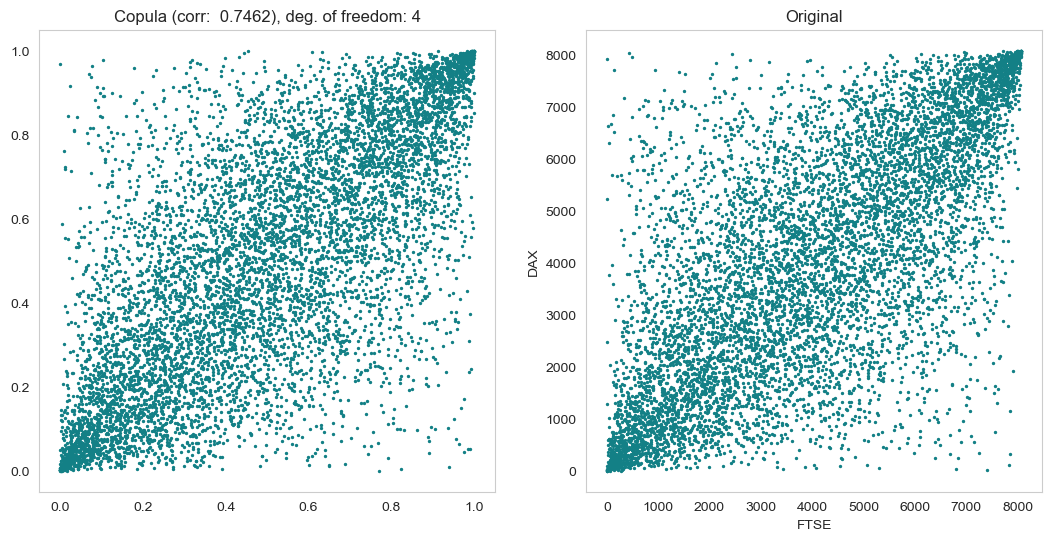

In [68]:
fig, axs = plt.subplots(ncols = 3, figsize = (20,6))
plot_copula(axs[0], axs[2], rho = 0.7461536, deg_freedom=4)
plot_rankscatter(ftse, dax, axs[1], title = "Original")

#### FTSE & S&P 500: Student copula
- rho: 0.473188
- df: 4.0000000 

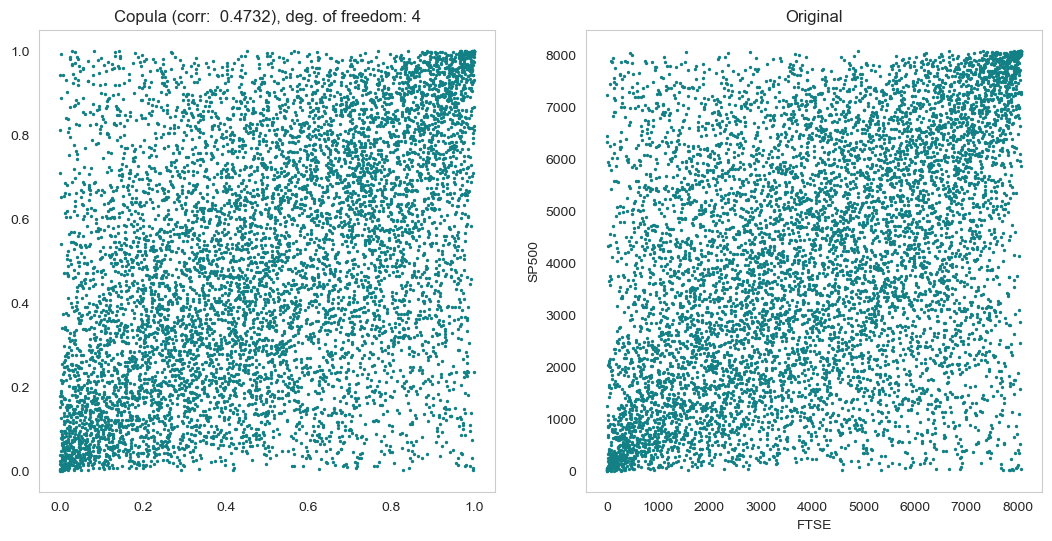

In [69]:
fig, axs = plt.subplots(ncols = 3, figsize = (20,6))
plot_copula(axs[0], axs[2], rho = 0.473188, deg_freedom=4)
plot_rankscatter(ftse, sp500, axs[1], title = "Original")

#### DAX & S&P 500: Student copula
- rho: 0.4878477
- df: 4.0000000 

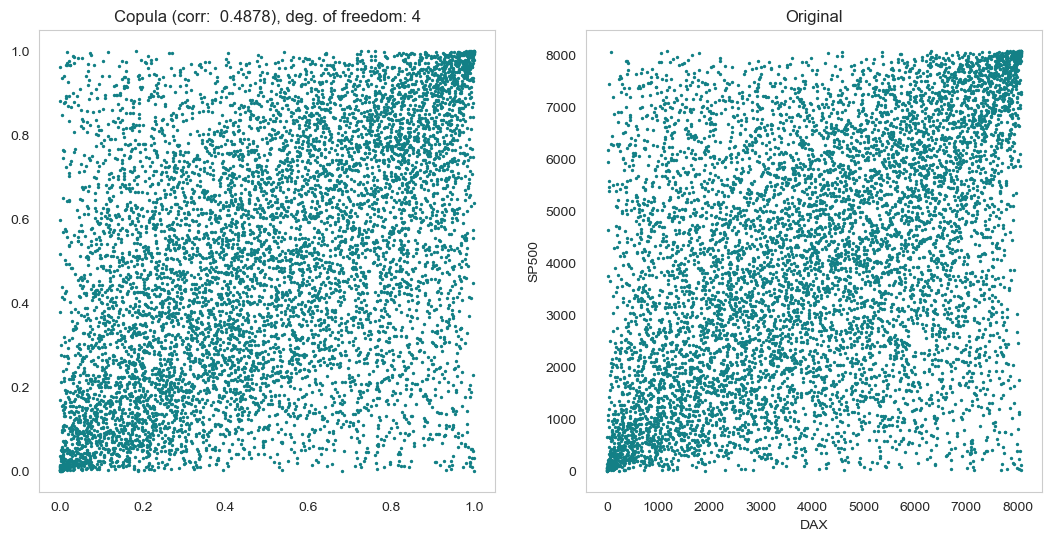

In [67]:
fig, axs = plt.subplots(ncols = 3, figsize = (20,6))
plot_copula(axs[0], axs[2], rho = 0.4878477, deg_freedom=4)
plot_rankscatter(dax, sp500, axs[1], title = "Original")